Возьмём для примера датасет недвижимости в Калифорнии, в котором решается задача регрессии (определение цены недвижимости).

→ Скачайте ноутбук с кодом

California Housing Dataset

MedInc — медианный уровень дохода в квартале;
HouseAge — медианный возраст дома в квартале;
AveRooms — среднее количество помещений;
AveBedrms — среднее количество спальных комнат;
Population — население квартала;
AveOccup — средний срок проживания;
Latitude — значение широты квартала;
Longitude — значение долготы квартала;
Price — целевое значение.
Загрузим датасет и посмотрим на него:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
 
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
 
data = fetch_california_housing()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df.loc[:,'target'] = data['target']
df.head(5)

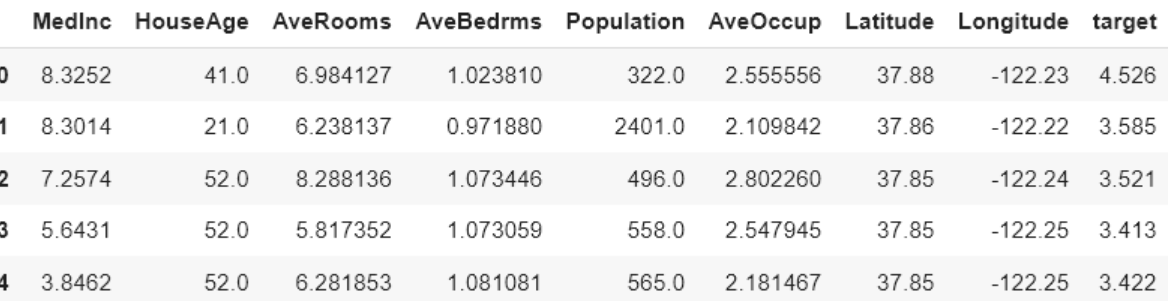

Определимся с метрикой, по которой будем оценивать качество модели — Root Mean Squared Error (RMSE), корень из среднего квадрата отклонения. Для этого на метод mean_squared_error подадим атрибут squared = False, который позволяет управлять возведением метрики в квадрат. Помимо RMSE для оценки качества модели будем использовать метрику R2.

def rmse(y_hat, y):
    return mean_squared_error(y_hat, y, squared = False)
 

Посмотрим на типы данных с помощью метода df.info().

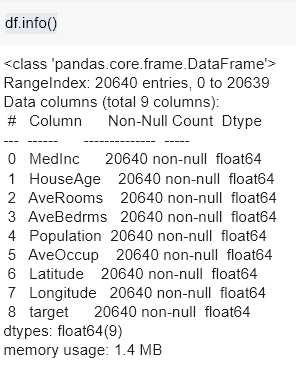

Видим, что данные исключительно типа float, поэтому мы можем в качестве предобработки применить к ним StandardScaler().

Разделим данные на обучающую и тестовую выборки, используя train_test_split: 

X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')
----------
Размер обучающей выборки (15480, 8)
Размер тестовой выборки (5160, 8)
Обучим простейший пайплайн, вызвав метод fit(), состоящий из случайного леса и стандартизации (StandardScaler). На вход пайплайна подается список из преобразований в формате кортежа (название метода преобразования, по которому мы будем обращаться в дальнейшем к нашему преобразованию, объект  метода преобразования). Например:

pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)
--------- 
Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
Посмотрим на метрики. Для этого сделаем предсказание пайплайном с помощью метода predict() и посчитаем R2 и RMSE с помощью функций r2_score() и rmse() соответственно. Округлим результат до четырёх цифр после запятой.

y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')
----------
Качество по метрике R2: 0.808
Качество по RSME: 0.5041
Теперь мы можем посмотреть на все параметры в пайплайне, вызвав метод get_params():

pipeline.get_params()

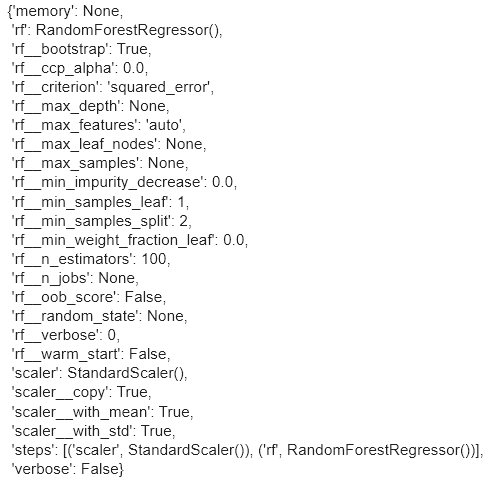

Примечание. В качестве альтернативного метода задания пайплайна можно использовать метод make_pipeline, на вход которого подаются объекты, которые будут использованы в пайплайне. В нашем случае:

from sklearn.pipeline import make_pipeline
make_pipeline(StandardScaler(), RandomForestRegressor())
Использование пайплайна в виде, полученном из make_pipeline, аналогично. 

Попробуем теперь обратиться к отдельной части пайплайна. Попробуем вызвать значение n_estimator у случайного леса. Мы можем это сделать двумя способами: индексацией пайплайна или обращением через имя, которые мы задали ранее при создании ('rf').

print(pipeline[1].n_estimators)
print(pipeline['rf'].n_estimators)
----------
100
100
Теперь попробуем задать этому же параметру значение 200. Можно это сделать, используя метод set_params(), на вход которого надо подавать конструкцию <название модуля>__<название параметра>. 

Обратите внимание на два нижних подчеркивания, которые используются в качестве литералов для разбиения названия модуля и названия его параметра. Без него компилятор будет неправильно интерпретировать параметр, который вы хотите изменить!

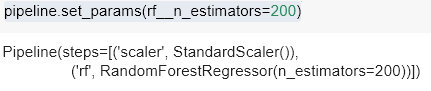

Данную структуру надо учитывать, когда для пайплайна задается GridSearch кросс-валидация. Попробуем взять 100, 200, 500 базовых моделей и сделать поиск оптимального параметра StardardScaler with_mean (типа bool, который отвечает за центровку данных, приводит распределение к нулевому среднему, по умолчанию — True. В противном случае среднее данных остается неизменным):

from sklearn.model_selection import GridSearchCV
param_grid = {'scaler__with_mean':[True,False],
              'rf__n_estimators':[100, 200, 500]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose = True)


grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

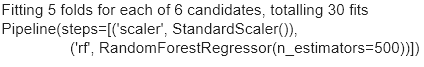

y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')
----------
 
Качество по метрике R2: 0.81
Качество по RSME: 0.5013
Как видим, качество улучшилось по обеим метрикам.

# Предобработка в пайплайнах

При использовании пайплайна для сборки обработки данных в один стек удобно воспользоваться Column Transformer.

Column Transformer — это специальный объект из модуля compose библиотеки sklearn, который позволяет применять набор трансформаций к данным. Этот объект позволяет преобразовывать разные столбцы или подмножества столбцов входных данных по отдельности, а результаты, сгенерированные каждым преобразователем, будут объединены в единую таблицу.

Однако, самим Column Transformer пользоваться не совсем удобно, для более удобной работы с ним мы будем использовать «обёртку» в виде функции make_column_transformer() из того же модуля библиотеки sklearn.

Разбираться с обработкой данных внутри пайплана будем на примере датасета рейтинга красного вина.

Для начала загрузим данные и посмотрим на них:

df_wine= pd.read_csv('Red.csv')
df_wine.head()

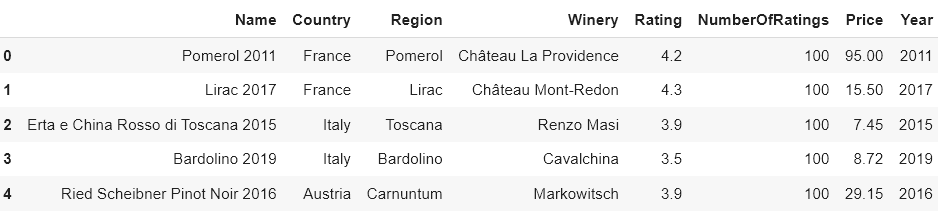

df_wine.info()

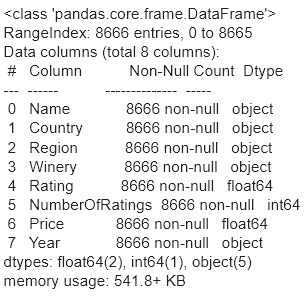
 

Например, у нас есть численный признак цена вина (Price) и категориальный регион производства (Region). Для первого надо применить StandardScaler(), для второго — OneHotEncoder(). Мы можем сделать это следующим образом:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']))
print(ct)

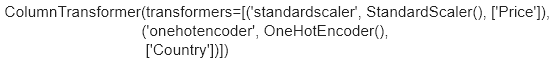

Примечание. Если мы хотим применить, например, OneHotEncoder, к более чем одному признаку, то просто достаточно добавить в список колонки, например ['Country', ‘Region’]. Теперь OneHotEncoder будет работать не только на признаке Country, но ещё и на Region.

Примечание. Можно также использовать фильтрацию по типу колонок, используя метод make_column_selector() из sklearn.compose. Например, следующий Column Transformer будет применять преобразование StandardScaler к числовым столбцам и OneHotEncoder к столбцам с типом данных object:

from sklearn.compose import make_column_selector
import numpy as np

ct_filtered = make_column_transformer(
       (StandardScaler(), make_column_selector(dtype_include=np.number)),
       (OneHotEncoder(), make_column_selector(dtype_include=object))
)

print(ct_filtered)
Полученный трансформер можно использовать в качестве элемента пайплайна, например: 

pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor())])
Давайте посмотрим на результат работы ColumnTransformer в пайплайне. Для этого обучим его на колонках Price и Country, а в качестве целевой метки используем рейтинг вина Rating.

X = df_wine[['Country', 'Price']]
y = df_wine['Rating']
pipeline.fit(X, y)

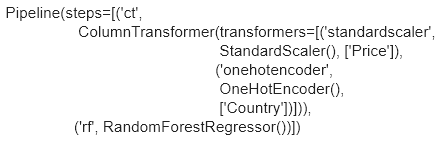

Теперь вызовем отдельно ct и преобразуем X. 

Важный момент: при отображении после преобразования ваш датасет будет представлен в виде sparse-матрицы (специальный формат для хранения больших, практически полностью нулевых матриц), поэтому надо будет вызвать метод toarray(). Так же мы можем получить названия колонок с onehotencoder с помощью метода .get_feature_names_out(), обратившись именно к энкодеру. 

pd.DataFrame(
    pipeline['ct'].transform(X).toarray(),
    columns=['Price'] + pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()
)

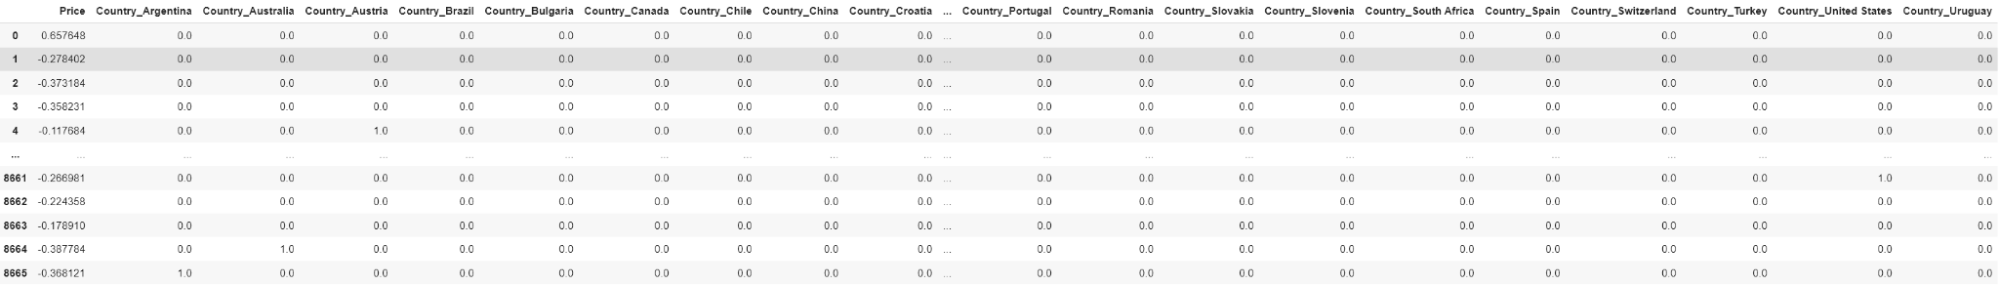
 

⭐️ Итак, мы научились использовать и собирать полноценный пайплайн, узнали о трансформациях колонок, которые позволяют легко и просто делать рутинные задачи типа нормализации/стандартизации и кодирования категориальных признаков. 

Обученный пайплайн можно сохранить в формат pickle, например, используя библиотеку joblib. Далее его можно использовать после десериализации как решение «из коробки», применяя следующие методы.

Примечание. Формат pickle реализует двоичный протокол для сериализации/десериализации объектов для сохранения и последующего использования без каких-либо дополнительных преобразований. Удобен для переноса обученных моделей, предобработки и так далее.

Сериализация — процесс перевода структуры данных в последовательность битов. 

Десериализация — процесс создания из последовательности битов  структуры данных.

!pip install joblib
import joblib
joblib.dump(pipeline, 'pipeline.pkl')


После этого ваш пайплайн будет сохранен в файл pipeline.pkl. Вы можете использовать свой пайплайн, импортировав все библиотеки из зависимостей (которые импортировались при создании пайплайна), используя следующие строчки кода:

pipeline_loaded = joblib.load('pipeline.pkl')
print(pipeline_loaded)

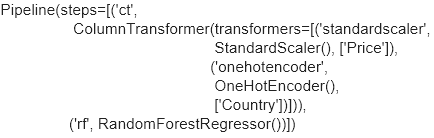

Как видим, пайплайн успешно сохранился.

Таким образом, мы можем использовать уже готовый пайплайн, например для проведения онлайн расчётов и постановки модели на постоянный регулярный расчёт. Под онлайн-расчётами мы подразумеваем сбор данных в формате онлайн и получения результатов модели в онлайне с помощью фреймворка, например AirFlow. Это необходимо для раскатки решения, например, на сайте (модель рекомендаций фильмов, схожие товары в интернет магазинах и так далее).